In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

# Parameter scans


In [7]:
def read_params_config(filename):
    df = pd.read_csv(filename, nrows=11)
    return df

def get_params_config(df, param):
    return df.loc[df['name'] == param]

def get_scan_file(search_dir):
    all_files = os.listdir(search_dir) 
    files = []
    for file in all_files:
        if "scan_" in file and ".csv" in file:
            files.append(os.path.join(search_dir ,file))
    return files

def get_scan_file_prefix(prefix):
    suffix_ordered =["_scan_mean_lambda.csv",
                    "_scan_gamma_lambda.csv",
                    "_scan_var_lambda.csv",
                    "_scan_mean_q.csv",
                    "_scan_gamma_q.csv",
                    "_scan_var_q.csv",
                    "_scan_beta.csv",
                    "_scan_var_x.csv",
                    "_scan_var_g.csv",
                    "_scan_var_dx.csv",
                    "_scan_var_dg.csv"]
    files = []
    for suffix in suffix_ordered:
        file = prefix + suffix
        if os.path.isfile(file):   
            files.append(file)
    return files


In [8]:
def read_1dscan(filename):
    tag = "scan_"
    base = filename.split("/")[-1]
    parameter = base[base.find(tag)+len(tag):-4]

    df = pd.read_csv(filename, skiprows=14)    
    return df[[parameter, 'likelihood']], parameter


def plot_1dscans(filenames, cols=3, width=14):
    rows = np.ceil(len(filenames)/cols).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(width,width/cols*rows))
    # fig = plt.figure()
    for i, ax in enumerate(axes.ravel()):
        if i<len(filenames):
            scan, parameter = read_1dscan(filenames[i])
            params_config = read_params_config(filenames[i])
            init = get_params_config(params_config, parameter)["init"].values[0]
            param_range = scan.to_numpy()[:,0]
            ll = scan.to_numpy()[:,1]
            init_idx = np.searchsorted(param_range, init)

            ax.plot(param_range,ll, label='scan')
            ax.axvline(x=init, label='simulation value', ls='--', color='tab:orange')
            ax.axhline(y=ll[init_idx], ls='--', color='tab:orange')

            ax.set_xlabel(parameter)
            ax.set_ylabel('log likelihood')
            ax.ticklabel_format(style='sci', scilimits=(0,1), useOffset=False)
            ax.legend()

        else:
            plt.delaxes(ax)

    plt.tight_layout()
    plt.show()



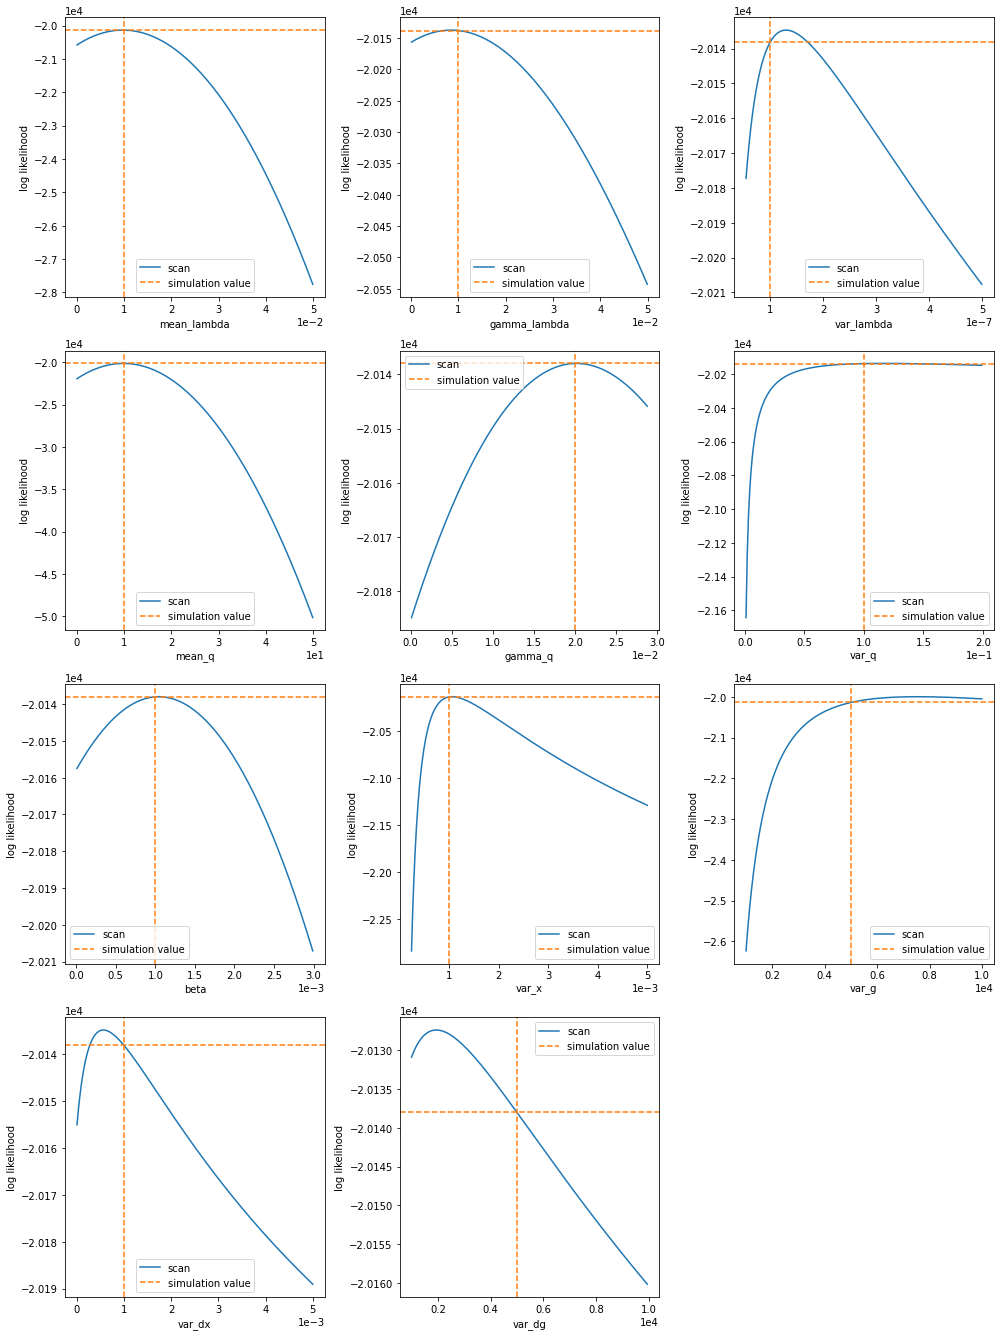

In [9]:
scan_files = get_scan_file_prefix('../data/out/simulation_shared_with_bjoern')
plot_1dscans(scan_files)


# Minimization

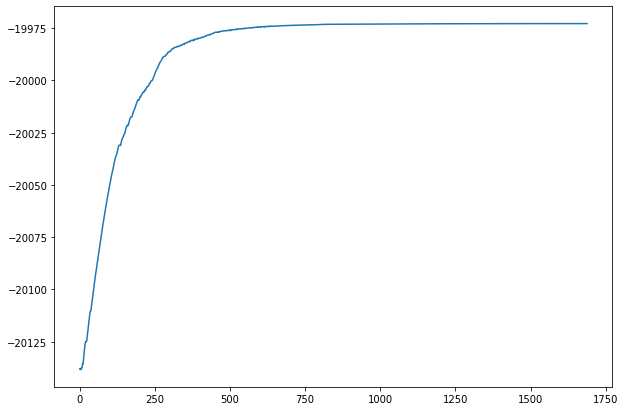

In [13]:

def read_minimization(filename):
    df = pd.read_csv(filename, skiprows=14)    
    return df[["iteration", 'likelihood']]

def plot_minimization(filename):
    mini_data = read_minimization(filename)
    fig, ax = plt.subplots(figsize=(10,7))
    iterations = mini_data.to_numpy()[:,0]
    ll = mini_data.to_numpy()[:,1]
    ax.plot(iterations, ll)
    ax.set_xlabel("iterations")
    plt.show()


plot_minimization('../data/out/simulation_shared_with_bjoern_f_b012345678910.csv')